In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm

# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
input_lang = 'fr'
target_lang = 'zh'
model_size = '7b'
custom_model = None
single_token_only = False
multi_token_only = False
out_dir = './visuals'

In [5]:
if single_token_only and multi_token_only:
    raise ValueError('single_token_only and multi_token_only cannot be True at the same time')

In [6]:
unemb = load_unemb_only(model_size)

Using 2 GPUs!


In [17]:
# prepare for energy plots
U = list(unemb.module[1].parameters())[0].detach().cpu().float()
weights = list(unemb.module[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5

U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


In [7]:
prefix = "./data/langs/"
df_en_fr = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_de = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()

In [8]:
if custom_model is not None:
    llama = LlamaHelper(dir=custom_model, load_in_8bit=True)
else:
    llama = LlamaHelper(dir='/dlabdata1/llama2_hf/Llama-2-%s-hf'%model_size, load_in_8bit=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
tokenizer = llama.tokenizer
model = llama.model

In [10]:
count = 0
for idx, word in enumerate(df_en_de['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1
        if multi_token_only:
            df_en_de.drop(idx, inplace=True)
    elif single_token_only:
        df_en_de.drop(idx, inplace=True)

print(f'for {target_lang} {count} of {len(df_en_de)} are single tokens')

if input_lang == target_lang:
    df_en_de_fr = df_en_de.copy()
    df_en_de_fr.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_de_fr = df_en_de.merge(df_en_fr, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_de_fr.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_de_fr.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_de_fr.drop(i, inplace=True)

print(f'final length of df_en_de_fr: {len(df_en_de_fr)}')

for zh 139 of 139 are single tokens
final length of df_en_de_fr: 118


In [11]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [12]:

id2voc = {id:voc for voc, id in llama.tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent='en'):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, 'en')
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [13]:
dataset = []
for ind in tqdm(range(len(df_en_de_fr))):
    d = next(sample(df_en_de_fr, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

100%|██████████| 118/118 [00:26<00:00,  4.47it/s]


In [14]:
df = pd.DataFrame(dataset)
os.makedirs(f'{os.path.join(out_dir, custom_model)}/translation', exist_ok=True)
if single_token_only:
    df.to_csv(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_dataset_single_token.csv', index=False)
elif multi_token_only:
    df.to_csv(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_dataset_multi_token.csv', index=False)
else:
    df.to_csv(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [15]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"Français: ""cinq"" - 中文: ""五""\nFrançais: ""cœur"" -...","[31784, 231]",云,"[17184, 274, 9570, 23642, 29883, 9274, 15126, ...",cloud,nuage
1,"Français: ""vallée"" - 中文: ""谷""\nFrançais: ""tribu...","[31473, 232]",包,"[2291, 29890, 289, 23156, 19548, 9922]",bag,sac
2,"Français: ""école"" - 中文: ""校""\nFrançais: ""versio...","[30856, 232]",口,"[13394, 4346, 29442, 29885, 2730, 21026, 286]",mouth,bouche
3,"Français: ""champ"" - 中文: ""场""\nFrançais: ""nord"" ...","[31181, 232]",土,"[578, 29879, 269, 577, 22473]",soil,sol
4,"Français: ""temps"" - 中文: ""时""\nFrançais: ""porte""...","[30329, 232]",山,"[16476, 4346, 29442, 29885, 2730, 286, 14378, ...",mountain,montagne
...,...,...,...,...,...,...
113,"Français: ""tentative"" - 中文: ""试""\nFrançais: ""la...","[31558, 235]",起,"[374, 3780, 364, 10107, 14451, 29878, 5161]",rise,hausse
114,"Français: ""visage"" - 中文: ""面""\nFrançais: ""juge""...","[31651, 232]",左,"[454, 29880, 1563, 301, 25874, 280, 2175]",left,gauche
115,"Français: ""océan"" - 中文: ""洋""\nFrançais: ""sable""...","[30941, 236]",音,"[29802, 3669, 578, 6047, 29879, 269, 577]",sound,son
116,"Français: ""chanson"" - 中文: ""歌""\nFrançais: ""son""...","[31074, 232]",力,"[12248, 29886, 1129, 3081, 13519, 4764, 772, 282]",power,pouvoir


In [18]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    latents = llama.latents_all_layers(d['prompt'])
    logits = unemb(latents)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

118it [03:59,  2.03s/it]


In [19]:
print(latents.shape)

torch.Size([118, 32, 4096])


/dlabdata1/wendler/code/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


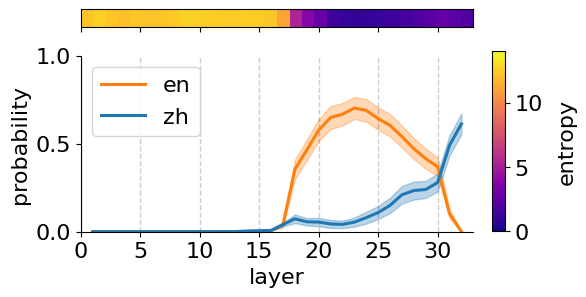

In [20]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, 'en', color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
if target_lang != 'en':
    plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
if model_size == '7b':
    ax2.set_ylabel('probability')
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{os.path.join(out_dir, custom_model)}/translation', exist_ok=True)
if single_token_only:
    plt.savefig(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent_single_token.pdf', dpi=300, bbox_inches='tight')
elif multi_token_only:
    plt.savefig(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent_multi_token.pdf', dpi=300, bbox_inches='tight')
else:
    plt.savefig(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.pdf', dpi=300, bbox_inches='tight')

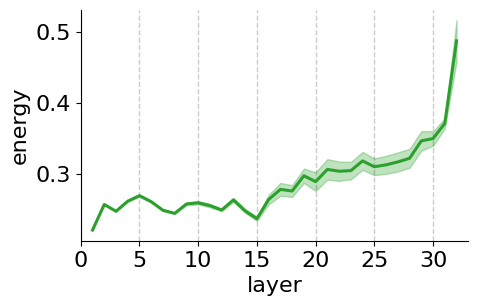

In [20]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
if model_size == '7b':
    ax2.set_ylabel('energy')
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{os.path.join(out_dir, custom_model)}/translation', exist_ok=True)
if single_token_only:
    plt.savefig(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent_single_token.pdf', dpi=300, bbox_inches='tight')
elif multi_token_only:
    plt.savefig(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent_multi_token.pdf', dpi=300, bbox_inches='tight')
else:
    plt.savefig(f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_energy.pdf', dpi=300, bbox_inches='tight')

In [21]:
if single_token_only:
    torch.save(latents, f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_latents_single_token.pt')
elif multi_token_only:
    torch.save(latents, f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_latents_multi_token.pt')
else:
    torch.save(latents, f'{os.path.join(out_dir, custom_model)}/translation/{model_size}_{input_lang}_{target_lang}_latents.pt')